In [1]:
import numpy as np
import datetime as dtm
import netCDF4 as nc
import numpy.ma as ma
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline

In [2]:
temperature = nc.Dataset('/mnt/storage0/jacquielee/data/woa13_A5B2_t00_04.nc')
salinity = nc.Dataset('/mnt/storage0/jacquielee/data/woa13_A5B2_s00_04.nc')

In [3]:
#salinity.variables

In [4]:
t_lon = temperature.variables['lon'][:]
t_lat = temperature.variables['lat'][:]
#t_depth = temperature.variables['depth'][:]
temp = temperature.variables['t_an'][0,:,:,:]

In [5]:
#s_lon = salinity.variables['lon'][:]
#s_lat = salinity.variables['lat'][:]
s_depth = salinity.variables['depth'][:]
sal = salinity.variables['s_an'][0,:,:,:]

In [5]:
##Check to make sure the variables are the same between data sets 

# if (t_lat == s_lat).all():
#     print('True')
# else:
#     print('False')
    
# if (t_lon == s_lon).all():
#     print('True')
# else:
#     print('False')
    
# if (t_depth == s_depth).all():
#     print('True')
# else:
#     print('False')

In [10]:
lon = t_lon
lat = t_lat
depth = s_depth

In [8]:
depth_neg = depth*(-1.0) # depth, lat, lon
print(depth_neg)

NameError: name 'depth' is not defined

In [9]:
lon.shape

(1440,)

In [10]:
import gsw

In [11]:
def Nsquared(SA, CT, p, lat=None):
    r"""Calculates the buoyancy frequency squared (N^2)(i.e. the Brunt-Väisälä
    frequency squared) at the mid pressure from the equation,
    .. math::
        N^2 = g^2 \frac{\partial\rho}{\partial p}

    Parameters
    ----------
    SA : array_like
         Absolute Salinity  [g/kg]
    CT : array_like
         Conservative Temperature [:math:`^\circ` C (ITS-90)]
    p : array_like
        sea pressure  [dbar]
    lat : array_like, optional
          latitude in decimal degrees north [-90..+90]
          If lat is not supplied, a default gravitational acceleration of
          9.7963 m/s^2 (Griffies, 2004) will be used.

    Returns
    -------
    N2 : array_like
         Brunt-Väisälä frequency squared [1 s :math:`-2`]
    p_mid : array_like
            Mid pressure between p grid [dbar]

    See Also
    --------
    TODO

    Notes
    -----
    This routine uses rho from the computationally efficient 48-term expression
    for density in terms of SA, CT and p.  Also that the pressure increment,
    :math:`\partial p`, in the above formula is in Pa, so that it is 10^4 times
    the pressure increment in dbar.

    The 48-term equation has been fitted in a restricted range of parameter
    space, and is most accurate inside the "oceanographic funnel" described in
    McDougall et al. (2011).  The GSW library function "infunnel(SA, CT, p)" is
    available to be used if one wants to test if some of one's data lies
    outside this "funnel".

    Examples
    --------
    TODO

    References
    ----------
    .. [1] IOC, SCOR and IAPSO, 2010: The international thermodynamic equation
    of seawater - 2010: Calculation and use of thermodynamic properties.
    Intergovernmental Oceanographic Commission, Manuals and Guides No. 56,
    UNESCO (English), 196 pp. See section 3.10 and Eqn. (3.10.2).

    ..[2] McDougall T.J., P.M. Barker, R. Feistel and D.R. Jackett, 2011:  A
    computationally efficient 48-term expression for the density of
    seawater in terms of Conservative Temperature, and related properties
    of seawater.

    ..[3] Griffies, S. M., 2004: Fundamentals of Ocean Climate Models.
    Princeton, NJ: Princeton University Press, 518 pp + xxxiv.

    Modifications:
    2011-03-22. Trevor McDougall & Paul Barker
    """

    if lat != None:
        g = gsw.grav(lat, p)
    else:
        g = 9.7963  # Standard value from Griffies (2004).

    SA, CT, p, g = np.broadcast_arrays(SA, CT, p, g)

    p_mid = 0.5 * (p[1:, ...] + p[:-1, ...])

    drho = (gsw.rho(SA[1:, ...], CT[1:, ...], p_mid) -
            gsw.rho(SA[:-1, ...], CT[:-1, ...], p_mid))

    grav_local = 0.5 * (g[1:, ...] + g[:-1, ...])
    dp = p[1:, ...] - p[:-1, ...]

    N2 = grav_local ** 2 * drho / (gsw.db2Pascal * dp)

    return N2, p_mid

In [15]:
p = np.zeros_like(sal,dtype=np.dtype('f8'))

for dep in np.arange(0,len(depth)):
    print(dep)
    for j in np.arange(0,len(lat)):
         p[dep,j,:] = gsw.p_from_z(depth_neg[dep],lat[j])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101


In [9]:
Ctemp = np.zeros_like(temp,dtype=np.dtype('f8'))
# for dep in z:
#     print(dep)
for i in np.arange(0,len(lon)):
    for j in np.arange(0,len(lat)):
            #print(nsquare[j,i],sal[:,j,i],temp[:,j,i],p[:,j,i],lat[j,i])
            Ctemp[:,j,i] = gsw.CT_from_t(sal[:,j,i],temp[:,j,i],p[:,j,i])


In [10]:
Ctemp.dump('/mnt/storage0/jacquielee/data/Ctemp_climatology.npy')

In [11]:
SA = np.zeros_like(sal,dtype=np.dtype('f8'))
# for dep in z:
#     print(dep)
for i in np.arange(0,len(lon)):
    for j in np.arange(0,len(lat)):
            #print(nsquare[j,i],sal[:,j,i],temp[:,j,i],p[:,j,i],lat[j,i])
            SA[:,j,i] = gsw.SA_from_SP(sal[:,j,i],p[:,j,i],lon[i],lat[j])

In [12]:
SA.dump('/mnt/storage0/jacquielee/data/SA_climatology.npy')

In [16]:
p.dump('/mnt/storage0/jacquielee/data/p_climatology.npy')

In [13]:
nsquare = np.zeros_like(p,dtype=np.dtype('f8'))
# for dep in z:
#     print(dep)
for i in np.arange(0,len(lon)):
    for j in np.arange(0,len(lat)):
            #print(nsquare[j,i],sal[:,j,i],temp[:,j,i],p[:,j,i],lat[j,i])
            nsquare[1:,j,i],p_mid = gsw.Nsquared(SA[:,j,i], Ctemp[:,j,i],p[:,j,i],lat[j])

/home/jacquielee/anaconda2/lib/python2.7/site-packages/numpy/ma/core.py:839: RuntimeWarning: invalid value encountered in less
  return umath.less(x, self.critical_value)


In [14]:
n2mask = (ma.getmaskarray(sal[:,:,:]))*1
nsquare = ma.array(nsquare,mask=n2mask)
nsquare.dump('/mnt/storage0/jacquielee/data/nsquare_climatology.npy')

In [12]:
p = np.load('/mnt/storage0/jacquielee/data/p_climatology.npy')
nsquare = np.load('/mnt/storage0/jacquielee/data/nsquare_climatology.npy')

In [15]:
#calculate average profile value of pressure and Nsquared
xlen = len(nsquare[0,:,0])
ylen = len(nsquare[0,0,:])

nsquare_zavg = np.zeros((xlen,ylen))

for ii in range(0,xlen):
    for jj in range(0,ylen):
        sums = np.sum(nsquare[:,ii,jj])
        count = 0
        for kk in np.arange(0,len(nsquare[:,0,0])):
            if nsquare[kk,ii,jj] == 0.0:
                continue
            else:
                count = count+1
        nsquare_zavg[ii,jj] = sums/count


/home/jacquielee/anaconda2/lib/python2.7/site-packages/numpy/ma/core.py:4089: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


KeyboardInterrupt: 

In [24]:
# print(nsquare[:,100,200])
# #print(nsquare_zavg[100,200])
# # print(np.sum(nsquare[:,100,200]))
# print(sal[:,100,200])
# print(temp[:,100,200])
# print(n_b[100,200])
n_b.max()

nan

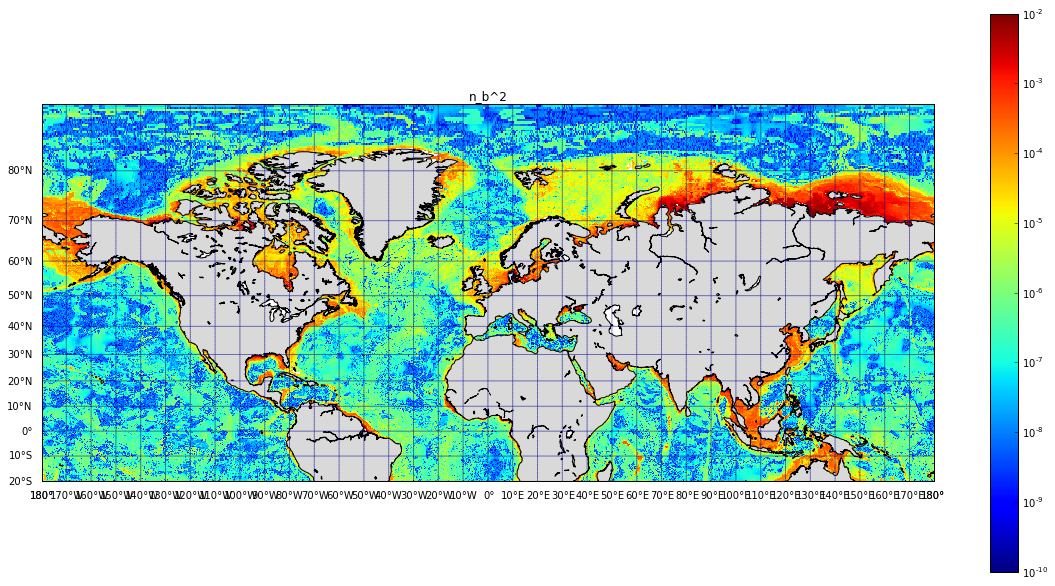

In [72]:

fig, ax = plt.subplots(1, 1, figsize=(20, 20))

cmap = plt.get_cmap('jet')
k_v = (n_b)**2
m = Basemap(projection='mill',llcrnrlat=-20,urcrnrlat=90,
            llcrnrlon=-180,urcrnrlon=180,resolution='l', ax=ax)
m.drawcoastlines()
m.fillcontinents(color = '0.85')
m.drawparallels(np.arange(-80.,90.,10.),labels=[1, 0, 0, 0],color='darkblue',latmax=90)
m.drawmeridians(np.arange(-180.,180.,10.),labels=[0, 0, 0, 1],color='darkblue',latmax=90)
nav_lon, nav_lat = np.meshgrid(lon[:], lat[:])
x_lon, y_lat = m(nav_lon, nav_lat)
m = m.pcolor(x_lon[:,:],y_lat[:,:],k_v[:,:],
                 norm=colors.LogNorm(vmin=10**(-10), vmax=10**(-2)))
                 #norm=colors.SymLogNorm(linthresh=10**(-7),vmin=-10**(-5), vmax=10**(-2)))
                 
cbar = fig.colorbar(m,ax=ax,shrink=0.5)
                    #ticks=[10**-2,10**-3,10**-4,10**-5,10**-6,10**-7,-10**-7,-10**-6,-10**-5],format='%.0e')
    #cbar.ax.set_yticklabels(['10**0','10**-2','10**-4','10**-6','10**-8'])
# clines = ax.contour(k_v[:,:],np.array([0.0]),colors=['black'])
# ax.clabel(clines, fmt='%1.1f')
ax.set_title("n_b^2")

In [20]:
def plot_base(zlevel,k_v,nav_lat,nav_lon,ax):
    #ved_part = np.ma.masked_values(veddy[zlevel,:,:], 10)
    m = Basemap(projection='mill',llcrnrlat=-20,urcrnrlat=90,
            llcrnrlon=-180,urcrnrlon=180,resolution='l', ax=ax)
    m.drawcoastlines()
    m.fillcontinents(color = '0.85')
    m.drawparallels(np.arange(-80.,90.,10.),labels=[1, 0, 0, 0],color='darkblue',latmax=90)
    m.drawmeridians(np.arange(-180.,180.,10.),labels=[0, 0, 0, 1],color='darkblue',latmax=90)
    lon, lat = np.meshgrid(nav_lon[:], nav_lat[:])
    x_lon, y_lat = m(lon, lat)
    m = m.pcolor(x_lon[:,:],y_lat[:,:],k_v[zlevel,:,:],
                 norm=colors.SymLogNorm(linthresh=10**(-16),vmin=k_v[zlevel,:,:].min(), vmax=k_v[zlevel:,:].max()))
                 #norm=colors.LogNorm(vmin=10**(-16), vmax=k_v.max()))
    cbar = fig.colorbar(m,ax=ax,shrink=0.5,ticks=[10**0,10**-4,10**-8,10**-12,10**-16,-10**-8,-10**-12,-10**-16],format='%.0e')
    #cbar.ax.set_yticklabels(['10**0','10**-2','10**-4','10**-6','10**-8'])
    clines = ax.contour(k_v[zlevel,:,:],np.array([0.0]),colors=['black'])
    ax.clabel(clines, fmt='%1.1f')
    #cbar.set_label('{label} [{units}]'.format(label=veddyv.long_name.title(), units=veddyv.units))
    #ax.set_title(u't = {t:.1f} Day, depth \u2248 {d:.2f}{z.units}'.format(t=7, d=zlevels[zlevel], z=zlevels))
    return True

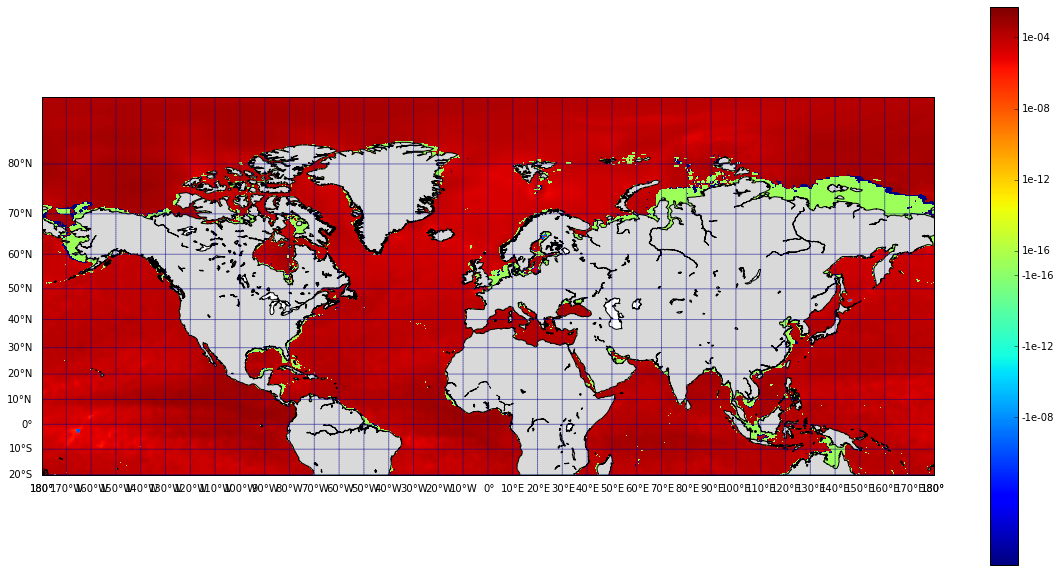

In [43]:
fig, ax = plt.subplots(1,1,figsize=(20,20))
## define colour map
cmap = plt.get_cmap('jet')

PLOT_OBJS = plot_base(10,nsquare,lat,lon,ax)

In [22]:
nsquare2 = np.load('/mnt/storage0/jacquielee/data/nsquare_ANHA4-EXH004_y2004m09d07.npy')
nsquare2.shape

(50, 800, 544)

In [23]:
tracers = nc.Dataset('/mnt/storage0/jacquielee/research/data/Jasper/ANHA4-EXH004_y2004m09d07_gridT.nc')

In [24]:
lat2 = tracers.variables['nav_lat'][:,:]
lon2 = tracers.variables['nav_lon'][:,:]

MemoryError: 

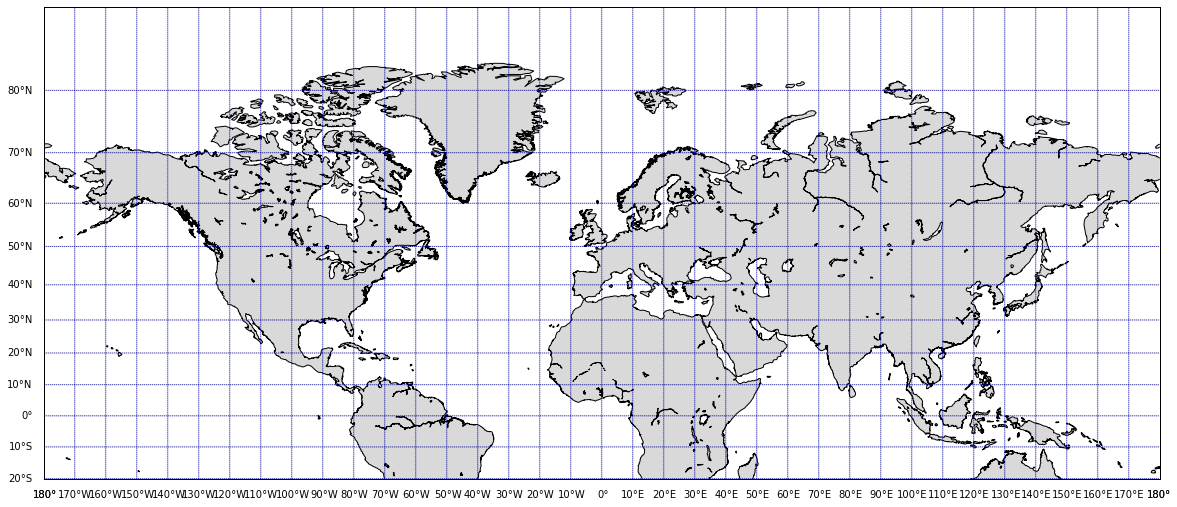

In [25]:
fig, ax = plt.subplots(1,1,figsize=(20,20))
PLOT_OBJS = plot_base(25,nsquare2,lat2,lon2,ax)

In [10]:
n2mask = (ma.getmaskarray(sal[:,:,:]))*1
nsquare = ma.array(nsquare,mask=n2mask)

In [11]:
nsquare.min()
if not ma.is_masked(nsquare[2,100,200]):
    print("FALSE")

FALSE


In [28]:
nsquare.shape

(102, 720, 1440)

In [12]:
z = np.arange(101,-1,-1)
x = np.arange(0,720)
y = np.arange(0,1440)
print(z)

[101 100  99  98  97  96  95  94  93  92  91  90  89  88  87  86  85  84
  83  82  81  80  79  78  77  76  75  74  73  72  71  70  69  68  67  66
  65  64  63  62  61  60  59  58  57  56  55  54  53  52  51  50  49  48
  47  46  45  44  43  42  41  40  39  38  37  36  35  34  33  32  31  30
  29  28  27  26  25  24  23  22  21  20  19  18  17  16  15  14  13  12
  11  10   9   8   7   6   5   4   3   2   1   0]


In [69]:
# to calclulate n_b - find the first non zero value in a column. 
n_b = np.zeros_like(p[0,:,:],dtype=np.dtype('f8'))

for i in x:
    print(i)
    for j in y:
        for k in z:
            if ma.is_masked(nsquare[k,i,j]):
                continue
            else:
                n_b[i,j] = nsquare[k,i,j]
                break
        
        



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [70]:
square = n_b[:,:]**2
sqrt_ = np.sqrt(square)
n_b = np.sqrt(sqrt_)
if n_b.all >= 0:
    print("TRUE")

TRUE


In [71]:
n_b.dump('/mnt/storage0/jacquielee/data/n_b_climatology.npy')

In [3]:
n_b = np.load('/mnt/storage0/jacquielee/data/n_b_climatology.npy')

In [14]:
nb2mask = (ma.getmaskarray(sal[0,:,:]))*1
n_b = ma.array(n_b,mask=nb2mask)

In [34]:
#n_b[np.isnan(n_b)] = 0.0
nsquare.min()

nan

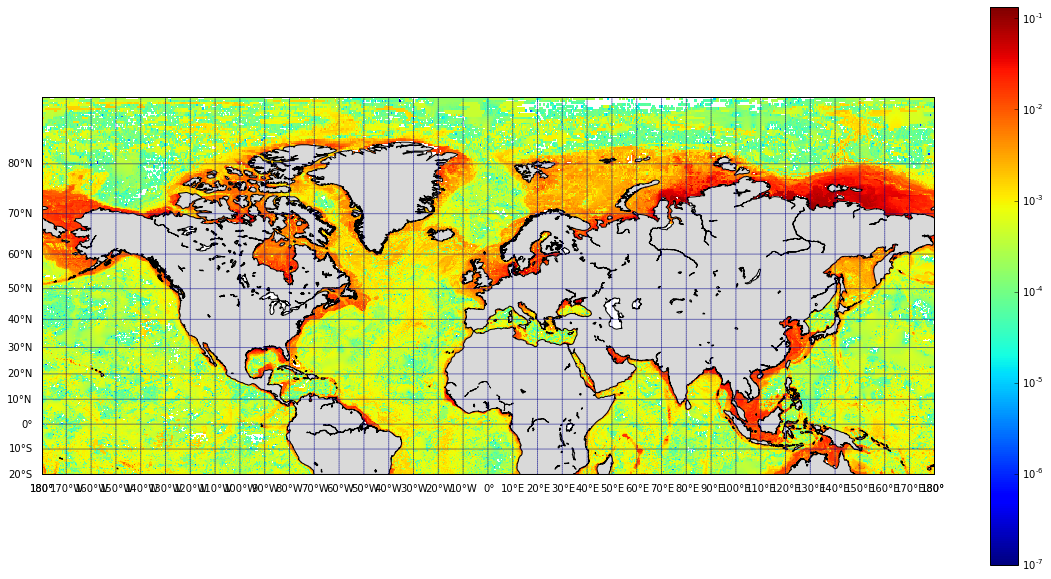

In [35]:
fig, ax = plt.subplots(1,1,figsize=(20,20))
m = Basemap(projection='mill',llcrnrlat=-20,urcrnrlat=90,
            llcrnrlon=-180,urcrnrlon=180,resolution='l', ax=ax)
m.drawcoastlines()
m.fillcontinents(color = '0.85')
m.drawparallels(np.arange(-80.,90.,10.),labels=[1, 0, 0, 0],color='darkblue',latmax=90)
m.drawmeridians(np.arange(-180.,180.,10.),labels=[0, 0, 0, 1],color='darkblue',latmax=90)
nav_lon, nav_lat = np.meshgrid(lon[:], lat[:])
x_lon, y_lat = m(nav_lon, nav_lat)
m = m.pcolor(x_lon[:,:],y_lat[:,:],n_b[:,:],
                 #norm=colors.SymLogNorm(linthresh=10**(-16),vmin=n_b.min(), vmax=n_b.max()))
                 norm=colors.LogNorm(vmin=10**(-7), vmax=n_b.max()))
cbar = fig.colorbar(m,ax=ax,shrink=0.5)
                    #ticks=[10**4,10**0,10**-4,10**-8,10**-12,10**-16,-10**-8,-10**-12,-10**-16],format='%.0e')
    #cbar.ax.set_yticklabels(['10**0','10**-2','10**-4','10**-6','10**-8'])


In [4]:

coordfile = nc.Dataset('/home/jacquielee/data/ANHA4_coordinates.nc')


navLon=coordfile.variables['nav_lon'][:]
navLat=coordfile.variables['nav_lat'][:]

In [5]:
from mpl_toolkits import basemap

In [11]:
ANHAh1 = basemap.interp(n_b,lon,lat,navLon, navLat,masked = 0,order=1)

ANHAh0 = basemap.interp(n_b,lon,lat,navLon, navLat,masked=0 ,order=0)

In [12]:
ANHAh1 = basemap.interp(n_b,lon,lat,navLon, navLat,masked = 0,order=1)

ANHAh0 = basemap.interp(n_b,lon,lat,navLon, navLat,masked=0 ,order=0)

In [13]:
mask0 = (ma.getmaskarray(ANHAh0))*1
mask1 = (ma.getmaskarray(ANHAh1))*1
ANHAh = np.zeros_like(ANHAh1,dtype=np.dtype('f8'))

for i in np.arange(0,ANHAh1[:,0].shape[0]):
    for j in np.arange(0,ANHAh1[0,:].shape[0]):
        if mask0[i,j] == mask1[i,j]:
            ANHAh[i,j] = ANHAh1[i,j]
        else:
            ANHAh[i,j] = ANHAh0[i,j]


In [14]:
grid = nc.Dataset('/home/jacquielee/data/ANHA4_bathy_etopo1_gebco1_smoothed_coast_corrected_mar10.nc')
bathy = grid.variables['Bathymetry'][:]
bathy = ma.masked_values(bathy[:],0)

In [15]:
anhamask = (ma.getmaskarray(bathy[:,:]))*1
new_grid1 = ma.array(ANHAh,mask=anhamask)

In [16]:
new_grid1 = ma.masked_values(new_grid1[:,:], 0.0)

/home/jacquielee/anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/home/jacquielee/anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3342: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/jacquielee/anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3381: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


Text(0.5,1,u'n_b interpolated onto ANHA4 grid')

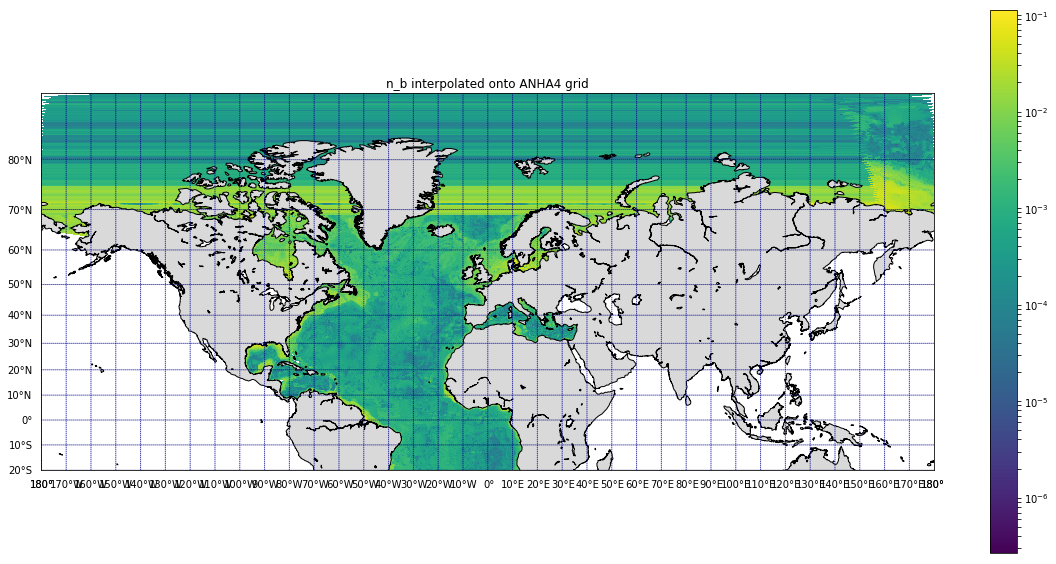

In [17]:
fig, ax = plt.subplots(1,1,figsize=(20,20))
m = Basemap(projection='mill',llcrnrlat=-20,urcrnrlat=90,
            llcrnrlon=-180,urcrnrlon=180,resolution='l', ax=ax)
m.drawcoastlines()
m.fillcontinents(color = '0.85')
m.drawparallels(np.arange(-80.,90.,10.),labels=[1, 0, 0, 0],color='darkblue',latmax=90)
m.drawmeridians(np.arange(-180.,180.,10.),labels=[0, 0, 0, 1],color='darkblue',latmax=90)
#nav_lon, nav_lat = np.meshgrid(lon[:], lat[:])
x_lon, y_lat = m(navLon, navLat)
m = m.pcolor(x_lon[:,:],y_lat[:,:],new_grid1,
                 #norm=colors.SymLogNorm(linthresh=0.0,vmin=new_grid1.min(), vmax=new_grid1.max()))
                 norm=colors.LogNorm(vmin=new_grid1.min(), vmax=new_grid1.max()))
cbar = fig.colorbar(m,ax=ax,shrink=0.5)
                    #ticks=[10**0,10**-4,10**-8,10**-12,10**-16],format='%.0e')
    #cbar.ax.set_yticklabels(['10**0','10**-2','10**-4','10**-6','10**-8'])
ax.set_title('n_b interpolated onto ANHA4 grid')

In [25]:
from geopy.distance import vincenty
def grid_dist(x_lon, y_lat, dist):
    '''calculate length and height for area
    assuming that grid cell is perfectly rectangular
    '''
    start = (y_lat[0],x_lon[0])
    
    endy = (y_lat[1],x_lon[1])
    dist[0] = vincenty(start,endy).meters
    
    endx = (y_lat[2],x_lon[2])
    dist[1] = vincenty(start,endx).meters
    return dist

def cell_area(i,j,lats,lons):
    ''' This function calls grid_dist to calculate grid cell height and length.
    Fist creates 2 1D arrays whose entries are coordinate +1 in y direction, original; coordinate, 
    coordinate +1 in x direction
    '''
    
    x_lon = np.array([lons[i+1,j],lons[i,j],lons[i,j+1]])
    y_lat = np.array([lats[i+1,j],lats[i,j],lats[i,j+1]])
    
    dist = np.zeros(2)
    HW = grid_dist(x_lon, y_lat,dist)
    area = HW[0]*HW[1]
    return area

In [32]:
energy = 0.0
area_full = 0.0
for i in np.arange(0,len(ANHAh[:,0])-1):
    for j in np.arange(0,len(ANHAh[0,:])-1):
        
        area = cell_area(i,j,navLat,navLon)
        if ma.is_masked(ANHAh[i,j]):
            continue
        else:
            area_full = area_full + area
            energy = energy+(ANHAh[i,j]*area)

In [33]:
print(energy/area_full)

0.00325780667875


In [26]:
import scipy.io as sio
mean_tidal_speed = sio.loadmat('/mnt/storage0/jacquielee/data/TIDAL/mean_tide_speed.mat', 
                       struct_as_record=False, squeeze_me=True)
mean_speed = mean_tidal_speed['mean_speed']
mean_speed = np.nan_to_num(mean_speed)
mean_speed0 = ma.array(mean_speed,mask=anhamask)

In [27]:
import math
grid = nc.Dataset('/mnt/storage0/jacquielee/data/hsquare.nc')
hsquare = grid.variables['hsquare']
hsquare = np.nan_to_num(hsquare)

rho_0 = 1024.0
q = 1.0/3.0
kappa = 2.0*math.pi/1500.0

In [30]:
energy1 = 0.0
area_full = 0.0
for i in np.arange(0,len(mean_speed0[:,0])-1):
    for j in np.arange(0,len(mean_speed0[0,:])-1):
        
        area = cell_area(i,j,navLat,navLon)
        area_full = area_full + area
        energy1 = energy1+(mean_speed[i,j]*area)

In [31]:
print(energy1/area_full)

0.0451219077446


In [28]:
anha_nb = new_grid1
anha_nb.dump('/mnt/storage0/jacquielee/data/anha4_nb_clomatology.npy')

In [29]:
E = 0.5*rho_0*anha_nb*kappa*hsquare*(mean_speed0**2)

In [41]:
E.dump('/mnt/storage0/jacquielee/data/E_climatology.npy')

In [42]:
E = np.load('/mnt/storage0/jacquielee/data/E_climatology.npy')

In [31]:
np.ma.set_fill_value(E,0.0)

In [32]:
E_new = ma.array(E,mask=anhamask)

In [37]:
int_x = np.where(E[600:720,275:310]==0)[0]+600
int_y = np.where(E[600:720,275:310]==0)[1]+275

In [38]:
# x = False
# y = True
# if x:
#     print("True")
# elif y:
#     print("True too")
#     x = False
# if x:
#     print("False")

print(range(2,3))

[2]


In [39]:
#fill in the missing values from the interpolation with an average of the values on either side latitudinally
block_start = True
block_end = False
for ii in np.arange(0,len(int_x)):
    if block_start:
        #if block start flag is true set the start of a latitude block
        index1 = ii
        block_start = False
        continue
    elif index1 != int_x[ii]:
        #if the index of the latidude block changes betweenthese indices then lat block is finished
        index2 = ii
        block_end = True
    if block_end:
        #if block end flag is flipped to true fill in the values
        if index1 == index2:
            E[int_x[index1], int_y[index1]] = (E[int_x[index1], int_y[index1-1]] + E[int_x[index1], int_y[index1+1]])/2.0
        else:
            fill = (E[int_x[index1]-1,int_y[index1]-1]+E[int_x[index2]+1,int_y[index2]+1])/2.0
            for kk in range(index1,index2+1):
                E[int_x[kk],int_y[kk]] = fill
        #reset blocks        
        block_start = True
        block_end = False


In [40]:
print(E[602,300:315])

[8.641697660653038e-06 1.0096917525823801e-07 5.606940033612942e-08
 1.059167004998186e-08 1.059167004998186e-08 1.2290349073399742e-10
 1.2290349073399742e-10 4.194236597129967e-09 8.472334835164249e-09
 2.4403933452536956e-10 4.937949860329465e-10 3.792957597479728e-09
 9.539242177007619e-10 1.6492119284339743e-09 2.354218804159512e-10]


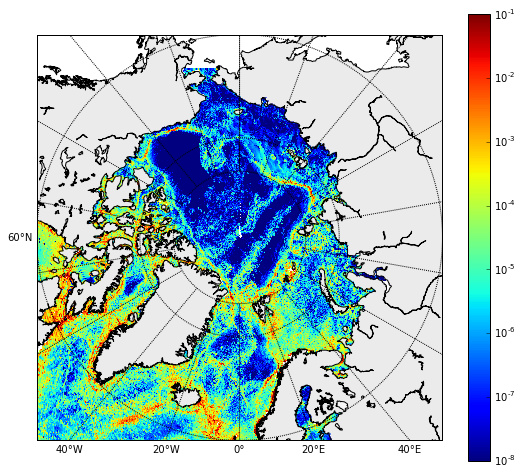

In [33]:
# fig, ax = plt.subplots(1,1,figsize=(20,20))
# m = Basemap(projection='mill',llcrnrlat=-20,urcrnrlat=90,
#             llcrnrlon=-180,urcrnrlon=180,resolution='l', ax=ax)
# m.drawcoastlines()
# m.fillcontinents(color = '0.85')
# m.drawparallels(np.arange(-80.,90.,10.),labels=[1, 0, 0, 0],color='darkblue',latmax=90)
# m.drawmeridians(np.arange(-180.,180.,10.),labels=[0, 0, 0, 1],color='darkblue',latmax=90)
# #nav_lon, nav_lat = np.meshgrid(lon[:], lat[:])
# x_lon, y_lat = m(navLon, navLat)
# m = m.pcolor(x_lon[:,:],y_lat[:,:],E,
#                  norm=colors.SymLogNorm(linthresh=10**(-16),vmin=E.min(), vmax=E.max()))
#              #norm=colors.LogNorm(vmin=10**(-16), vmax=k_v.max()))
# cbar = fig.colorbar(m,ax=ax,shrink=0.5,ticks=[10**4,10**0,10**-4,10**-8,10**-12,10**-16,-10**-8,-10**-12,-10**-16],format='%.0e')
#     #cbar.ax.set_yticklabels(['10**0','10**-2','10**-4','10**-6','10**-8'])
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(1,2,1)
m = Basemap(projection='npstere',boundinglat=60,lon_0=0,resolution='l')
m.drawcoastlines()
m.fillcontinents(color = '0.85',alpha=0.5)
m.drawparallels(np.arange(-90.,90.,15.),labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(-180.,181.,20.),labels=[0, 0, 0, 1])
cmap = plt.get_cmap('jet')
x_lons, y_lats = m(navLon,navLat)
m = m.pcolor(x_lons[:,:], y_lats[:,:],E[:,:],cmap=cmap,
             norm=colors.LogNorm(vmin=10**(-8), vmax=0.1))
#cbar = fig.colorbar(m,ax=ax)
plt.colorbar(shrink=0.4)
plt.show()

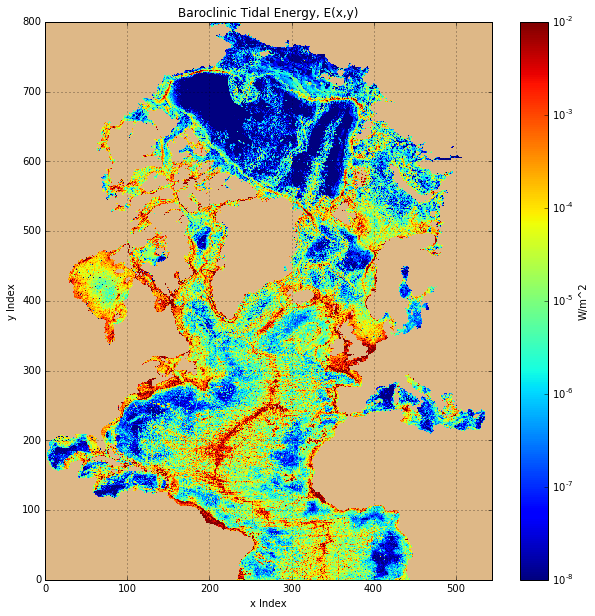

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
cmap = plt.get_cmap('jet')
cmap.set_bad('burlywood')
#clines = ax.contour(E,0.0,colors='white')
mesh = ax.pcolormesh(E,norm=colors.LogNorm(vmin=10**(-8), vmax=0.01),cmap=cmap)
                     #norm=colors.SymLogNorm(linthresh=0.00000001, 
                                             # linscale=0.00000001,vmin=0.0, vmax=500),cmap=cmap)

cbar = fig.colorbar(mesh,ax=ax)
                    #ticks=[0.0,10e-7,10e-5,10e-4,10e-3,10e-2,10e-1,10e0,10e1,10e2],ax=ax,format='%.1e')
cbar.set_label('W/m^2')
plt.axis((0, E.shape[1], 0, E.shape[0]))

#clines = ax.contour(E,0.0,colors='white')
ax.grid()
ax.set_title('Baroclinic Tidal Energy, E(x,y)')
ax.set_xlabel('x Index')
ax.set_ylabel('y Index')

In [43]:
x = np.arange(0,544)
y = np.arange(0,800)

for i in x:
    for j in y:
        if E[j,i] is ma.masked:
            E[j,i] = 0.0
        else:
            print('False')


False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

In [44]:
E.max()

9.6755517686330208

In [45]:
E.dump('/mnt/storage0/jacquielee/data/E_climatology.npy')

In [46]:
from netCDF4 import Dataset

nrows = 800
ncols = 544

netfile = Dataset('/mnt/storage0/jacquielee/data/E_climatology.nc', 'w', format='NETCDF3_64BIT')

In [47]:
netfile.createDimension('x', nrows)
netfile.createDimension('y', ncols)

<type 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 544

In [48]:
Lon  = netfile.createVariable('nav_lon', 'f4', ('x', 'y'))
Lat  = netfile.createVariable('nav_lat', 'f4', ('x', 'y'))
E_clim  = netfile.createVariable('E', 'f8', ('x', 'y'))

In [49]:
Lon[:,:] = navLon
Lat[:,:] = navLat
E_clim[:,:] = E

In [50]:
netfile.close()

In [27]:
from netCDF4 import Dataset

nrows = 800
ncols = 544

netfile = Dataset('/mnt/storage0/jacquielee/data/Nb_climatology.nc', 'w', format='NETCDF3_64BIT')

In [28]:
netfile.createDimension('x', nrows)
netfile.createDimension('y', ncols)

<type 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 544

In [29]:
Lon  = netfile.createVariable('nav_lon', 'f4', ('x', 'y'))
Lat  = netfile.createVariable('nav_lat', 'f4', ('x', 'y'))
Nb_clim  = netfile.createVariable('nb', 'f8', ('x', 'y'))

In [30]:
Lon[:,:] = navLon
Lat[:,:] = navLat
Nb_clim[:,:] = new_grid1
netfile.close()

In [22]:
new_grid1.shape

(800, 544)